In [1]:
import sys
sys.path.append('/home/luca/GitRepositories/Brancher')

# Bayesian statistics with Brancher

Computers are glorified calculators. Similarly, probabilistic programming is glorified (usually Bayesian) statistics. Therefore, the simplest use of Brancher is as an agile and intuitive toolbox for performing Bayesian inference in few variables.

The starting point of all Bayesian models is a probabilistic generative model:

 $$ p(x|z) p(z)~, $$
 
where $x$ is an observabla variable and $z$ is a latent variable. 
In this model, $p(x|z)$ (the likelihood) is basically a recipe for generating data $x$ as a stochastic function of an unobservable variable $z$. On the other hand, $p(z)$ (the prior) represents your knowledge of $z$ before observing $x$.  

The goal of Baysian inference is to obtain the posterior distribution of $z$ given the model and the observed value of $x$. This posterior is given by the Bayes theorem:

$$ p(z|x) = \frac{p(x| z) p(z)}{p(x)}~. $$

It is not trivial to directly use this formula in most real-wold problems (the tricky bit is the innocuous looking term $p(x)$). Brancher deals with this difficulty using an approximate technique called \amph{stochastic variational inference}. We we deal with the inference later on. For now, let's see how to write generative models in Brancher:

## Bulding the Beta Binomial Model

On of the simplest example of generative model is the Beta-Binomial model. Imagine that you are tring to determine is a coin is fair by tossing it $n = 10$ times. Assume that $\rho$ is the (unobservable) true probability of the coin landing on head. The probability of observing head $k$ times is given by a Binomial distribution:

$$
p(k|\rho) = \text{Binomial}\left(n, \rho \right)~.
$$

Now that the likelihood has been specified, we can complete the generative model by specifying a prior. The only strict requirement here is that the probability (density) of $\rho$ should be cointained in the interval $[0,1]$ since $\rho$ is a probability. A mathematically convevient choice is the Beta distribution:

$$
\rho \sim \text{Beta}\left(a, b \right)~.
$$

Let's now write this model in Brancher. The first step is to import the relevant classes of random variables from the standard_variables submodule:

In [2]:
from brancher.standard_variables import BinomialVariable as Binomial
from brancher.standard_variables import BetaVariable as Beta

In brancher, Beta and Binomial are classes that can be used for initializing the random variables that will form the building blocks of our generative model. For example, let's initialize the $\rho$ variable:

In [3]:
rho = Beta(alpha=1., beta=1., name="rho")

where $\alpha$ and $\beta$ are parameters of the Beta distribution. Now that we have $\rho$, we can initialize $k$ as a binomial variable that depends on $\rho$:

In [4]:
k = Binomial(n=10, p=rho, name="k")

This completes our simple model! We just need to insert the variables we constreucted in a ProbabilisticModel object:

In [5]:
from brancher.variables import ProbabilisticModel 

model = ProbabilisticModel([rho, k])

Done, the generative model is now fully encoded as a brancher object!

# Observing the model

So far we did not specify that the number of heads $k$ has been oberved. Let's say that we got $8$ heads, we can tell this to brancher by calling the "observe" method:

In [6]:
k.observe(8)

# Getting ready for the inference: the variational model

Our goal is now to determine the probability of $\rho$ (yes it is the probability of a probability, a bit confusing...) given the fact that we observed 8 heads. 

Brancher can solve this problem for you by fitting the parameter of an approximate posterior model. We will refer to this model as the "variational model". We need to create a variational model that contains all the non-observed variables in your generative model. Variational models are just probabilistic models and can be created in the very same way. The simplest way to make an appropriate model is to "copy the prior". More formally, we create an approximate posterior that follows the same distribution of the prior.

In [7]:
Qrho = Beta(alpha=1., beta=1., name="rho", learnable=True)
variational_model = ProbabilisticModel([Qrho])

The only difference here is that we set the learnable flag as True. This is important since we need to fit the parameters alpha and beta of Qrho in order to approximate the real posterior. We can now set our variational model as approximate posterior:

In [8]:
model.set_posterior_model(variational_model)

## Performing the inference

Most of the work is done! Now we can just ask brancher to fit the parameters of the posterior model:

In [9]:
from brancher import inference 

inference.perform_inference(model,
                            number_iterations=3000,
                            number_samples=10,
                            lr=0.1,
                            optimizer='Adam')


/home/luca/GitRepositories/Brancher/brancher/inference.py:61: UserWarning: The inference method was not specified, using the default reverse KL variational inference
  warnings.warn("The inference method was not specified, using the default reverse KL variational inference")
100%|██████████| 3000/3000 [00:08<00:00, 344.71it/s]


We can wo get the loss and plot it to see if the posterior parameters converged:

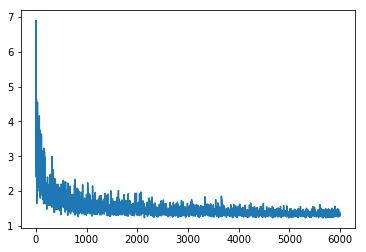

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_list = model.diagnostics["loss curve"]
plt.plot(loss_list)

Everything seems to be fine. We can finally plot the resulting (approximate) posterior:

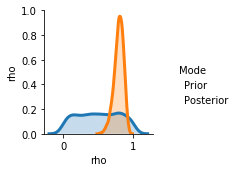

In [12]:
from brancher.visualizations import plot_posterior

plot_posterior(model, variables=["rho"]) #TODO: to be fixed